In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#Load already prepared CK+
def load_CKplus_full():
  x = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/inputs.csv",header=None)
  y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/labels.csv",header=None)
  x, y = shuffle(x, y,random_state = 2021)

  x = np.array(x)
  x = x.reshape(len(x),48,48,1)
  y = np.array(y)
  return x, y

def load_CKplus_split():
  x = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/inputs.csv",header=None)
  y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/labels.csv",header=None)
  x, y = shuffle(x, y,random_state = 2021)
  x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=147, random_state=2021)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=147, random_state=2021)

  x_train = np.array(x_train)
  x_train = x_train.reshape(len(x_train),48,48,1)
  y_train = np.array(y_train)
  x_test = np.array(x_test)
  x_test = x_test.reshape(len(x_test),48,48,1)
  y_test = np.array(y_test)
  x_val = np.array(x_val)
  x_val = x_val.reshape(len(x_val),48,48,1)
  y_val = np.array(y_val)
  return x_train, y_train, x_test, y_test, x_val, y_val

#Load already prepared FER2013
def load_FER2013():
  x_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/x_train.csv",header=None,)
  y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/y_train.csv",header=None)
  x_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/x_test.csv",header=None)
  y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/y_test.csv",header=None)
  x_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/x_val.csv",header=None)
  y_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/y_val.csv",header=None)

  x_train = np.array(x_train)
  x_train = x_train.reshape(len(x_train),48,48,1)
  y_train = np.array(y_train)
  x_test = np.array(x_test)
  x_test = x_test.reshape(len(x_test),48,48,1)
  y_test = np.array(y_test)
  x_val = np.array(x_val)
  x_val = x_val.reshape(len(x_val),48,48,1)
  y_val = np.array(y_val)
  return x_train, y_train, x_test, y_test, x_val, y_val


x_train, y_train, x_test, y_test, x_val, y_val = load_FER2013()
x_train.shape, x_test.shape, x_val.shape


def plot_model_history(history):
  # Plot training loss values
  print("Plot loss values (Train vs. Validation)")
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['loss'],label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

  print("Plot the accuracy (Train and Validation)")
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['accuracy'],label='Training Accuracy')
  plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()


In [3]:
#face recognition packages
!pip install opencv-python
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 23 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=46ea81935aad575c59e8d812a881fff3261e29f79f984f261a2ccf56b1843b25
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [4]:
#face detection, crop, sharpen, emboss using both face_recognition and cv2 packages
import face_recognition
from skimage.feature import local_binary_pattern
import cv2
import math
from google.colab.patches import cv2_imshow
from PIL import Image, ImageEnhance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def transform(img):
  if len(img.shape)>2:
    img = img.reshape(48,48)
  #gamma
  mid = 0.5 
  mean = np.mean(img)
  gamma = math.log(mid*255)/math.log(mean)
  img = np.power(img, gamma).clip(0,255).astype(np.uint8)

  #img = Image.fromarray(img)
  #filter = ImageEnhance.Contrast(img)# add contrast
  #img = filter.enhance(2)

  #img = img.filter(ImageEnhance.ImageFilter.SMOOTH)
  #img = img.filter(ImageEnhance.ImageFilter.EMBOSS)#emboss
  #img = img.filter(ImageEnhance.ImageFilter.EDGE_ENHANCE)
  
  #img = local_binary_pattern(img, 30, 1)
  #img = np.array(img)
  return img
def pre_process(input, target, output_height=48, output_width=48):
  face_cascade_name = cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml'
  face_cascade = cv2.CascadeClassifier()
  if not face_cascade.load(cv2.samples.findFile(face_cascade_name)):
    print("Error loading xml file")
    exit(0)

  x_temp = []
  y_temp = []
  #plt.figure(figsize=[8,8])
  for i in range(len(input)):
    img = np.array(input[i],'uint8')
    face_detect_1 = face_recognition.face_locations(img) #Using face_recoginition
    face_detect_2 = face_cascade.detectMultiScale(img,1.1, 1) #Using cv2
    if (len(face_detect_1)>0):
      (y, w, h, x) = face_detect_1[0]
      #img = img[y:y + h, x:x + w]
      #img = cv2.resize(img,(output_height, output_width))
      
      img = transform(img)
      img = img.reshape(output_height,output_width,1)
      x_temp.append(img)
      y_temp.append(target[i])

    elif (len(face_detect_2)>0):
      (x, y, w, h) = face_detect_2[0]
      #img = img[y:y + h, x:x + w]
      #img = cv2.resize(img, (output_height, output_width))
      
      img = transform(img)
      img = img.reshape(output_height,output_width,1)
      x_temp.append(img)
      y_temp.append(target[i])

    #cv2.rectangle(img, (x, y), (x+w, y+h), (0,0,0), 1)
    #print(i, x, y, w, h)

  x_temp = np.array(x_temp)
  y_temp = np.array(y_temp)
  return x_temp, y_temp

x_train, y_train = pre_process(x_train, y_train)
x_test, y_test = pre_process(x_test, y_test)
x_val, y_val = pre_process(x_val, y_val)

#For conveniency when training
trainx = x_train.copy()
trainy = y_train.copy()
testx = x_test.copy()
testy = y_test.copy()
valx = x_val.copy()
valy = y_val.copy()

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(22279, 48, 48, 1) (2749, 48, 48, 1) (2755, 48, 48, 1)
(22279, 1) (2749, 1) (2755, 1)


Display 50 images from the train set in the form of 5x5 matrix with their respective labels:


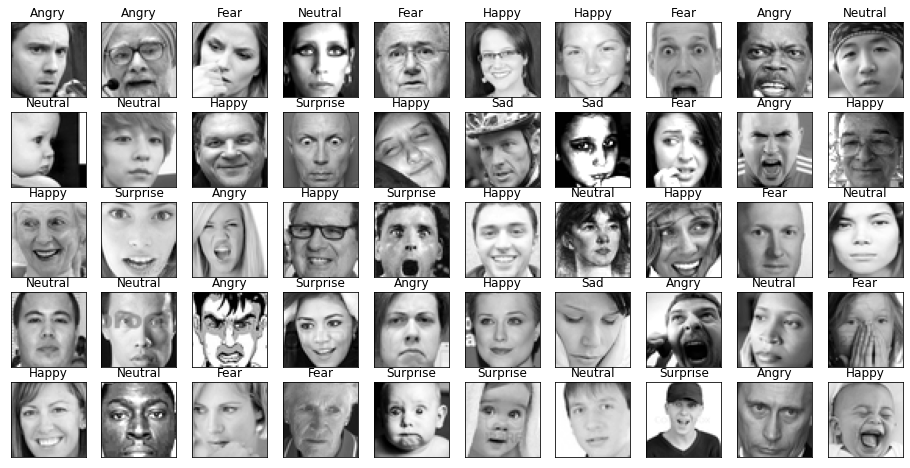

In [ ]:
import matplotlib.pyplot as plt
# Displaying 25 images from training dataset in 5x5 matrix
emotion={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'} #for FER2013
#emotion = {0:'anger',1:'contempt',2:'disgust',3:'fear',4:'happy',5:'sadness',6:'surprise'} #for CK+
def plot_image(input_images,labels):
  print("Display 50 images from the train set in the form of 5x5 matrix with their respective labels:")
  plt.figure(figsize=[16,8])
  for i in range(50):
    plt.subplot(5,10,1+i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(input_images[i].reshape([48,48]), cmap='gray')
    plt.title(emotion[int(labels[i])])
  plt.show()

plot_image(x_train,y_train)


Begin validation fold number:  1
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.01
44/44 [==============================] - 47s 514ms/step - loss: 1.9541 - accuracy: 0.2648 - val_loss: 2.3083 - val_accuracy: 0.1734
Epoch 2/50
Learning rate:  0.01
44/44 [==============================] - 20s 440ms/step - loss: 1.7763 - accuracy: 0.3379 - val_loss: 2.4748 - val_accuracy: 0.1850
Epoch 3/50
Learning rate:  0.01
44/44 [==============================] - 20s 444ms/step - loss: 1.5477 - accuracy: 0.4505 - val_loss: 2.1252 - val_accuracy: 0.2996
Epoch 4/50
Learning rate:  0.01
44/44 [==============================] - 20s 448ms/step - loss: 1.4335 - accuracy: 0.4983 - val_loss: 2.0497 - val_accuracy: 0.2693
Epoch 5/50
Learning rate:  0.01
44/44 [==============================] - 20s 446ms/step - loss: 1.3775 - accuracy: 0.5216 - val_loss: 3.3814 - val_accuracy: 0.3276
Epoch 6/50
Learning rate:  0.01
44/44 [==============================] - 20s 445ms/step - loss: 1.3238 - accurac

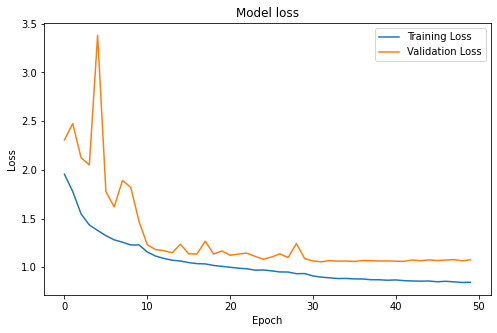

Plot the accuracy (Train and Validation)


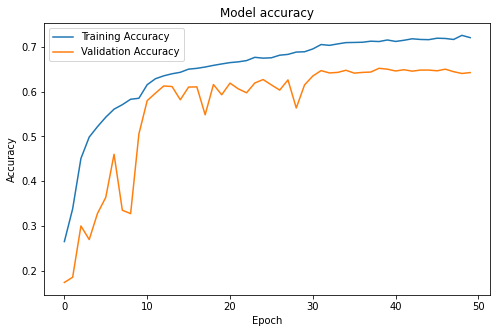

87/87 [==============================] - 2s 22ms/step - loss: 1.0551 - accuracy: 0.6563


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Begin validation fold number:  2
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.01
44/44 [==============================] - 20s 447ms/step - loss: 1.1602 - accuracy: 0.6096 - val_loss: 1.8857 - val_accuracy: 0.5126
Epoch 2/50
Learning rate:  0.01
44/44 [==============================] - 20s 444ms/step - loss: 1.1328 - accuracy: 0.6195 - val_loss: 1.3708 - val_accuracy: 0.5158
Epoch 3/50
Learning rate:  0.01
44/44 [==============================] - 20s 445ms/step - loss: 1.1009 - accuracy: 0.6285 - val_loss: 1.4685 - val_accuracy: 0.4970
Epoch 4/50
Learning rate:  0.01
44/44 [==============================] - 20s 445ms/step - loss: 1.0958 - accuracy: 0.6331 - val_loss: 1.3016 - val_accuracy: 0.5709
Epoch 5/50
Learning rate:  0.01
44/44 [==============================] - 20s 443ms/step - loss: 1.0844 - accuracy: 0.6371 - val_loss: 1.3532 - val_accuracy: 0.5557
Epoch 6/50
Learning rate:  0.01
44/44 [==============================] - 20s 445ms/step - loss: 1.0776 - accurac

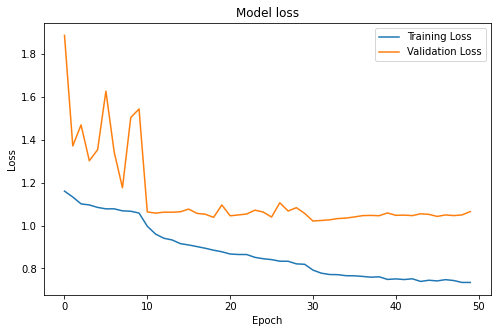

Plot the accuracy (Train and Validation)


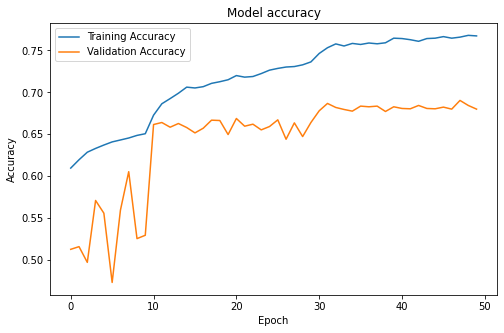

87/87 [==============================] - 2s 22ms/step - loss: 1.0232 - accuracy: 0.6900
Begin validation fold number:  3
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.01
44/44 [==============================] - 20s 444ms/step - loss: 1.1008 - accuracy: 0.6341 - val_loss: 1.8449 - val_accuracy: 0.4459
Epoch 2/50
Learning rate:  0.01
44/44 [==============================] - 20s 443ms/step - loss: 1.0629 - accuracy: 0.6540 - val_loss: 1.9921 - val_accuracy: 0.4487
Epoch 3/50
Learning rate:  0.01
44/44 [==============================] - 20s 441ms/step - loss: 1.0468 - accuracy: 0.6529 - val_loss: 1.2723 - val_accuracy: 0.5829
Epoch 4/50
Learning rate:  0.01
44/44 [==============================] - 20s 441ms/step - loss: 1.0239 - accuracy: 0.6634 - val_loss: 1.6246 - val_accuracy: 0.5613
Epoch 5/50
Learning rate:  0.01
44/44 [==============================] - 20s 443ms/step - loss: 1.0286 - accuracy: 0.6615 - val_loss: 1.2862 - val_accuracy: 0.5793
Epoch 6/50
Learning rate

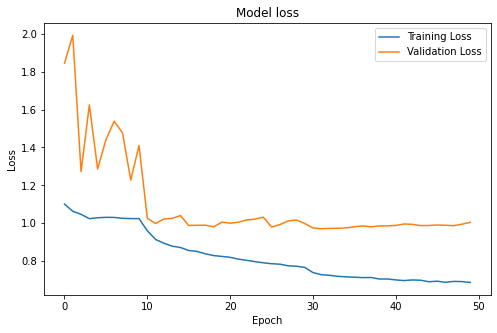

Plot the accuracy (Train and Validation)


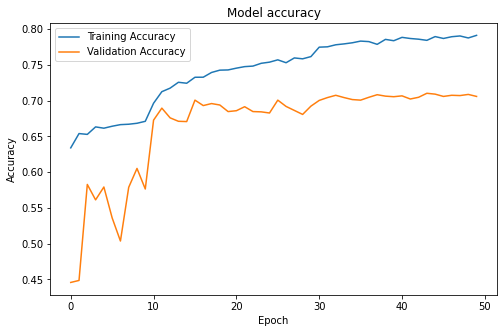

87/87 [==============================] - 2s 21ms/step - loss: 1.0462 - accuracy: 0.6893
Begin validation fold number:  4
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.01
44/44 [==============================] - 20s 444ms/step - loss: 1.1234 - accuracy: 0.6446 - val_loss: 1.7987 - val_accuracy: 0.4634
Epoch 2/50
Learning rate:  0.01
44/44 [==============================] - 20s 444ms/step - loss: 1.0684 - accuracy: 0.6708 - val_loss: 1.4237 - val_accuracy: 0.5437
Epoch 3/50
Learning rate:  0.01
44/44 [==============================] - 20s 444ms/step - loss: 1.0496 - accuracy: 0.6705 - val_loss: 1.3231 - val_accuracy: 0.5949
Epoch 4/50
Learning rate:  0.01
44/44 [==============================] - 20s 443ms/step - loss: 1.0293 - accuracy: 0.6802 - val_loss: 1.6767 - val_accuracy: 0.5342
Epoch 5/50
Learning rate:  0.01
44/44 [==============================] - 20s 446ms/step - loss: 1.0218 - accuracy: 0.6745 - val_loss: 1.8572 - val_accuracy: 0.5174
Epoch 6/50
Learning rate

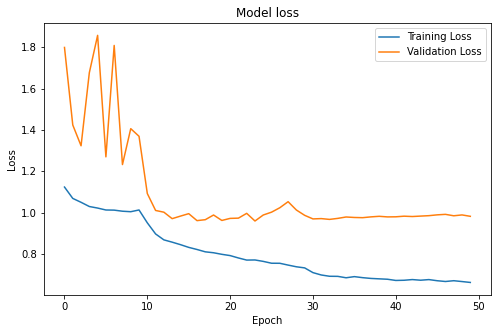

Plot the accuracy (Train and Validation)


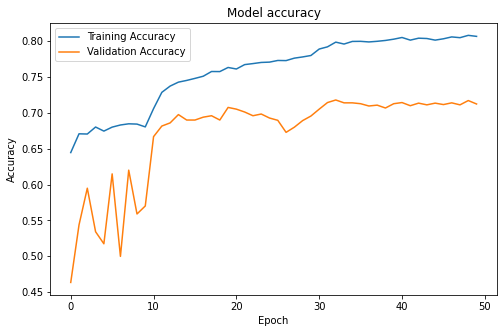

87/87 [==============================] - 2s 20ms/step - loss: 1.0231 - accuracy: 0.7027
Begin validation fold number:  5
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.01
44/44 [==============================] - 20s 445ms/step - loss: 1.0533 - accuracy: 0.6602 - val_loss: 5.3154 - val_accuracy: 0.3767
Epoch 2/50
Learning rate:  0.01
44/44 [==============================] - 20s 444ms/step - loss: 1.0412 - accuracy: 0.6703 - val_loss: 1.5031 - val_accuracy: 0.5441
Epoch 3/50
Learning rate:  0.01
44/44 [==============================] - 20s 442ms/step - loss: 1.0072 - accuracy: 0.6814 - val_loss: 1.3245 - val_accuracy: 0.5937
Epoch 4/50
Learning rate:  0.01
44/44 [==============================] - 20s 441ms/step - loss: 1.0010 - accuracy: 0.6824 - val_loss: 1.2926 - val_accuracy: 0.6117
Epoch 5/50
Learning rate:  0.01
44/44 [==============================] - 20s 446ms/step - loss: 0.9986 - accuracy: 0.6871 - val_loss: 1.2247 - val_accuracy: 0.6029
Epoch 6/50
Learning rate

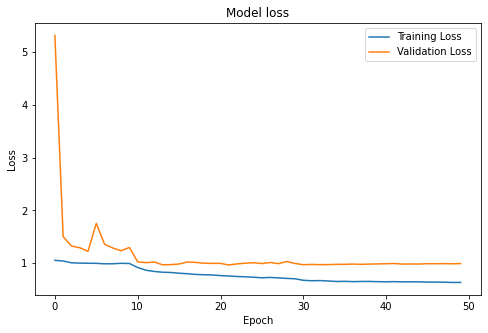

Plot the accuracy (Train and Validation)


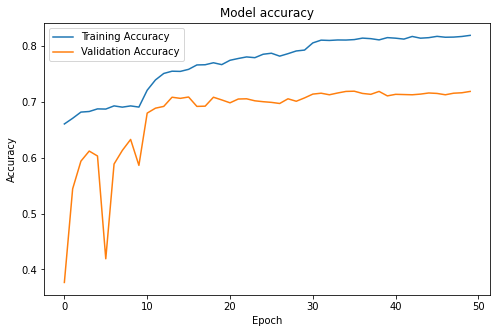

87/87 [==============================] - 2s 22ms/step - loss: 1.0634 - accuracy: 0.6987


In [6]:
#CBAM with cross validation (from fold 1 to 5)

from __future__ import print_function
import keras
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import resnet_v1, mobilenets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import os
import callbacks as cb

# Training parameters
batch_size = 512
epochs = 50
data_augmentation = True
num_classes = 7
subtract_pixel_mean = False  # Subtracting pixel mean improves accuracy
attention_module = 'cbam_block'
base_model = 'MobileNet'
# Choose what attention_module to use: cbam_block / se_block / None
model_type = base_model if attention_module==None else base_model+' '+attention_module

x = np.concatenate((x_train, x_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

#x, y = pre_process(x, y)
kfold = KFold(n_splits = 10, shuffle=True, random_state=2021)

# Input image dimensions.
input_shape = x.shape[1:]

# Convert class vectors to binary class matrices.
y = to_categorical(y, num_classes)
y_test = to_categorical(y_test, num_classes)

depth = 20 # For ResNet, specify the depth (e.g. ResNet50: depth=50, ResNet101: Depth=101)
model = resnet_v1.resnet_v1(input_shape=input_shape, depth=depth,num_classes=num_classes, attention_module='cbam_block')
#model = mobilenets.MobileNet(input_shape=input_shape, classes=num_classes, attention_module='cbam_block')
#model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(), #SGD(decay=2e-5, momentum=0.9, nesterov=True),
              metrics=['accuracy'])
#model.summary()

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
def lr_schedule(epoch):
    lr = 0.01
    if epoch >= (epochs*0.6):
      lr = 0.0001
    elif epoch >= (epochs*0.2):
      lr=0.001
    print('Learning rate: ', lr)
    return lr

# 1 cycle learning rate
cbs = cb.OneCycleSchedulerCallback(cyc_iterations= 2 * 23 * math.ceil(len(x_train) / batch_size) + 1,
                                      ramp_iterations=4 * math.ceil(len(x_train) / batch_size),
                                      min_lr=0.01,
                                      max_lr=0.1,
                                      min_mom=0.8,
                                      max_mom=0.95)


lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.01)
callbacks = [checkpoint, lr_reducer, lr_scheduler]


folds = 1
for train, val in kfold.split(x, y):
  print("Begin validation fold number: ", folds)
  # Run training, with or without data augmentation.
  if not data_augmentation:
      print('Not using data augmentation.')
      #history = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs,validation_data=(x_val, y_val), shuffle=True,callbacks=callbacks)
      history = model.fit(x[train], y[train],batch_size=batch_size, epochs=epochs,validation_data=(x[val], y[val]),shuffle=True, callbacks=callbacks)
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          # set input mean to 0 over the dataset
          featurewise_center=False,
          # set each sample mean to 0
          samplewise_center=False,
          # divide inputs by std of dataset
          featurewise_std_normalization=False,
          # divide each input by its std
          samplewise_std_normalization=False,
          # apply ZCA whitening
          zca_whitening=False,
          # epsilon for ZCA whitening
          zca_epsilon=1e-06,
          # randomly rotate images in the range (deg 0 to 180)
          rotation_range=0,
          # randomly shift images horizontally
          width_shift_range=0.1,
          # randomly shift images vertically
          height_shift_range=0.1,
          # set range for random shear
          shear_range=0.,
          # set range for random zoom
          zoom_range=0.,
          # set range for random channel shifts
          channel_shift_range=0.,
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          # value used for fill_mode = "constant"
          cval=0.,
          # randomly flip images
          horizontal_flip=True,
          # randomly flip images
          vertical_flip=False,
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.0)

      # Compute quantities required for featurewise normalization
      # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x[train])

      # Fit the model on the batches generated by datagen.flow().
      #history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
      history = model.fit(datagen.flow(x[train], y[train], batch_size=batch_size),
                      validation_data=(x[val], y[val]),
                      epochs=epochs, verbose=1, workers=4,
                      callbacks=callbacks)
  # plot the training   
  plot_model_history(history)
  # Score trained model.
  scores = model.evaluate(x_test, y_test)
  model.save('my_'+ str(folds) + '_model.h5')
  folds += 1
  if (folds>5):
    break
  


Begin validation fold number:  6
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.01
44/44 [==============================] - 20s 433ms/step - loss: 1.0461 - accuracy: 0.6693 - val_loss: 2.0933 - val_accuracy: 0.4778
Epoch 2/50
Learning rate:  0.01
44/44 [==============================] - 19s 432ms/step - loss: 1.0228 - accuracy: 0.6820 - val_loss: 1.4700 - val_accuracy: 0.5737
Epoch 3/50
Learning rate:  0.01
44/44 [==============================] - 20s 436ms/step - loss: 1.0086 - accuracy: 0.6843 - val_loss: 1.1215 - val_accuracy: 0.6556
Epoch 4/50
Learning rate:  0.01
44/44 [==============================] - 20s 439ms/step - loss: 0.9944 - accuracy: 0.6948 - val_loss: 1.6021 - val_accuracy: 0.5410
Epoch 5/50
Learning rate:  0.01
44/44 [==============================] - 20s 437ms/step - loss: 0.9886 - accuracy: 0.6908 - val_loss: 1.5249 - val_accuracy: 0.5114
Epoch 6/50
Learning rate:  0.01
44/44 [==============================] - 20s 437ms/step - loss: 0.9920 - accurac

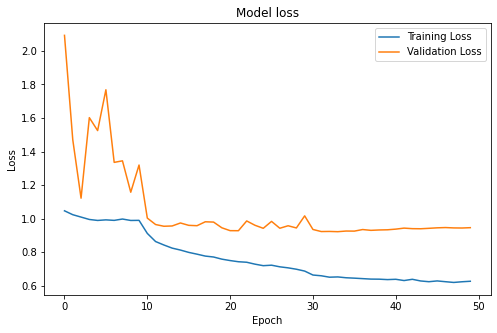

Plot the accuracy (Train and Validation)


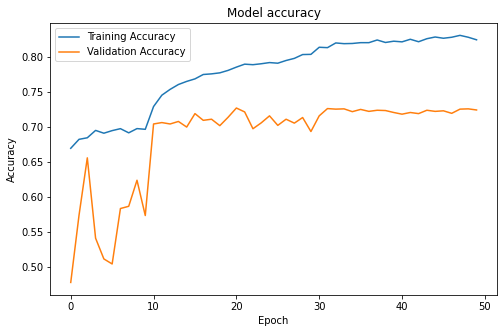

87/87 [==============================] - 2s 21ms/step - loss: 1.0909 - accuracy: 0.6995


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Begin validation fold number:  7
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.01
44/44 [==============================] - 20s 442ms/step - loss: 1.0353 - accuracy: 0.6762 - val_loss: 2.3798 - val_accuracy: 0.4650
Epoch 2/50
Learning rate:  0.01
44/44 [==============================] - 20s 442ms/step - loss: 1.0145 - accuracy: 0.6874 - val_loss: 1.2683 - val_accuracy: 0.6308
Epoch 3/50
Learning rate:  0.01
44/44 [==============================] - 20s 446ms/step - loss: 0.9949 - accuracy: 0.6970 - val_loss: 1.2533 - val_accuracy: 0.6404
Epoch 4/50
Learning rate:  0.01
44/44 [==============================] - 20s 442ms/step - loss: 0.9755 - accuracy: 0.7025 - val_loss: 1.3316 - val_accuracy: 0.5881
Epoch 5/50
Learning rate:  0.01
44/44 [==============================] - 20s 443ms/step - loss: 0.9796 - accuracy: 0.7058 - val_loss: 1.4914 - val_accuracy: 0.5661
Epoch 6/50
Learning rate:  0.01
44/44 [==============================] - 20s 442ms/step - loss: 0.9839 - accurac

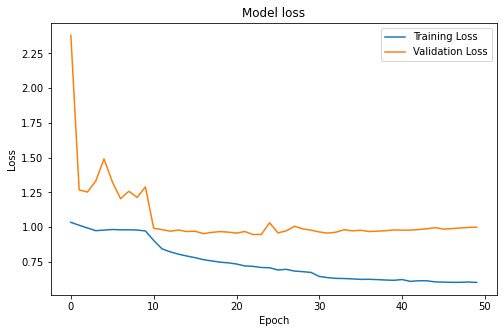

Plot the accuracy (Train and Validation)


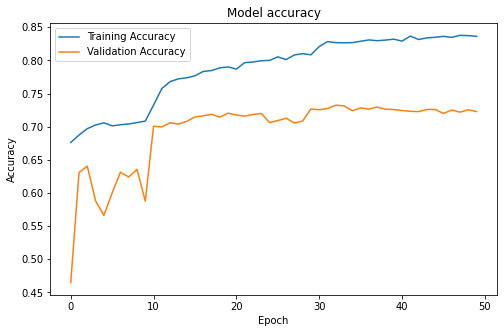

87/87 [==============================] - 2s 20ms/step - loss: 1.1220 - accuracy: 0.7020
Begin validation fold number:  8
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.01
44/44 [==============================] - 20s 446ms/step - loss: 1.0455 - accuracy: 0.6806 - val_loss: 1.7145 - val_accuracy: 0.5445
Epoch 2/50
Learning rate:  0.01
44/44 [==============================] - 20s 446ms/step - loss: 0.9995 - accuracy: 0.6978 - val_loss: 1.4289 - val_accuracy: 0.5785
Epoch 3/50
Learning rate:  0.01
44/44 [==============================] - 20s 443ms/step - loss: 0.9878 - accuracy: 0.7040 - val_loss: 1.1619 - val_accuracy: 0.6392
Epoch 4/50
Learning rate:  0.01
44/44 [==============================] - 20s 439ms/step - loss: 0.9763 - accuracy: 0.7042 - val_loss: 1.2072 - val_accuracy: 0.6225
Epoch 5/50
Learning rate:  0.01
44/44 [==============================] - 20s 442ms/step - loss: 0.9781 - accuracy: 0.7063 - val_loss: 1.5091 - val_accuracy: 0.5665
Epoch 6/50
Learning rate

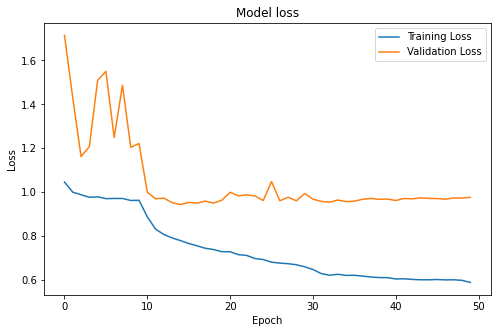

Plot the accuracy (Train and Validation)


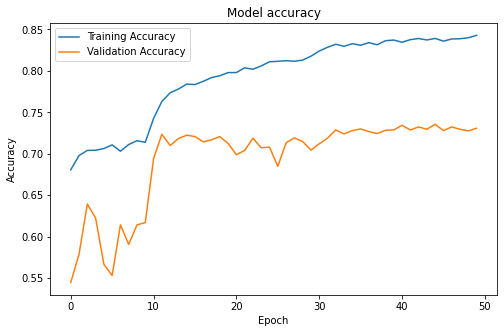

87/87 [==============================] - 2s 21ms/step - loss: 1.1078 - accuracy: 0.7060
Begin validation fold number:  9
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.01
44/44 [==============================] - 21s 468ms/step - loss: 1.0206 - accuracy: 0.6869 - val_loss: 1.9738 - val_accuracy: 0.4632
Epoch 2/50
Learning rate:  0.01
44/44 [==============================] - 20s 441ms/step - loss: 1.0069 - accuracy: 0.6948 - val_loss: 1.2279 - val_accuracy: 0.6207
Epoch 3/50
Learning rate:  0.01
44/44 [==============================] - 20s 443ms/step - loss: 0.9864 - accuracy: 0.7057 - val_loss: 1.2413 - val_accuracy: 0.6407
Epoch 4/50
Learning rate:  0.01
44/44 [==============================] - 20s 442ms/step - loss: 0.9668 - accuracy: 0.7093 - val_loss: 1.1677 - val_accuracy: 0.6411
Epoch 5/50
Learning rate:  0.01
44/44 [==============================] - 20s 442ms/step - loss: 0.9730 - accuracy: 0.7094 - val_loss: 1.3669 - val_accuracy: 0.6071
Epoch 6/50
Learning rate

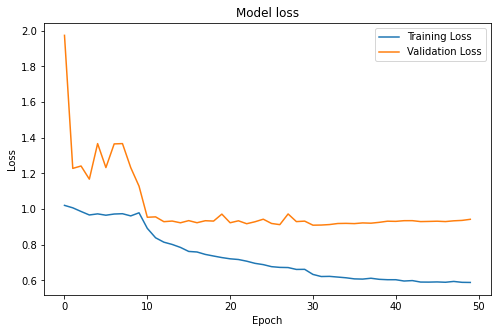

Plot the accuracy (Train and Validation)


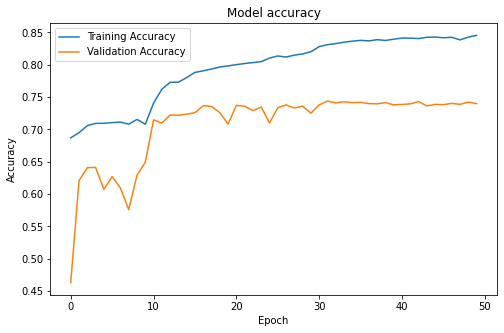

87/87 [==============================] - 2s 23ms/step - loss: 1.1078 - accuracy: 0.7100
Begin validation fold number:  10
Using real-time data augmentation.
Epoch 1/50
Learning rate:  0.01
44/44 [==============================] - 20s 444ms/step - loss: 1.0153 - accuracy: 0.6888 - val_loss: 2.2677 - val_accuracy: 0.4528
Epoch 2/50
Learning rate:  0.01
44/44 [==============================] - 20s 448ms/step - loss: 0.9956 - accuracy: 0.6994 - val_loss: 1.2527 - val_accuracy: 0.6043
Epoch 3/50
Learning rate:  0.01
44/44 [==============================] - 20s 438ms/step - loss: 0.9832 - accuracy: 0.7077 - val_loss: 1.3900 - val_accuracy: 0.5647
Epoch 4/50
Learning rate:  0.01
44/44 [==============================] - 20s 441ms/step - loss: 0.9645 - accuracy: 0.7165 - val_loss: 1.2053 - val_accuracy: 0.6355
Epoch 5/50
Learning rate:  0.01
44/44 [==============================] - 20s 439ms/step - loss: 0.9670 - accuracy: 0.7098 - val_loss: 2.0178 - val_accuracy: 0.5180
Epoch 6/50
Learning rat

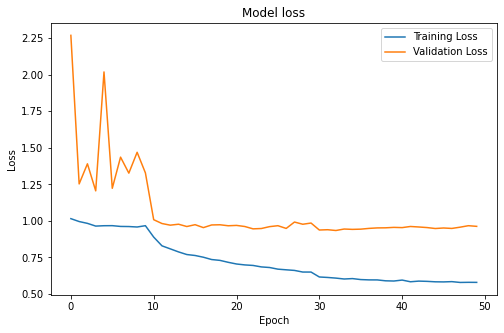

Plot the accuracy (Train and Validation)


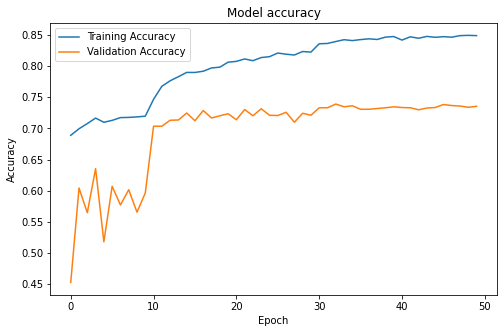

87/87 [==============================] - 2s 22ms/step - loss: 1.1305 - accuracy: 0.7024


In [7]:
#CBAM with cross validation (from fold 6 to 10)

folds = 1
for train, val in kfold.split(x, y):
  if folds<6:
    folds +=1
    continue
  print("Begin validation fold number: ", folds)
  # Run training, with or without data augmentation.
  if not data_augmentation:
      print('Not using data augmentation.')
      #history = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs,validation_data=(x_val, y_val), shuffle=True,callbacks=callbacks)
      history = model.fit(x[train], y[train],batch_size=batch_size, epochs=epochs,validation_data=(x[val], y[val]),shuffle=True, callbacks=callbacks)
  else:
      print('Using real-time data augmentation.')
      # This will do preprocessing and realtime data augmentation:
      datagen = ImageDataGenerator(
          # set input mean to 0 over the dataset
          featurewise_center=False,
          # set each sample mean to 0
          samplewise_center=False,
          # divide inputs by std of dataset
          featurewise_std_normalization=False,
          # divide each input by its std
          samplewise_std_normalization=False,
          # apply ZCA whitening
          zca_whitening=False,
          # epsilon for ZCA whitening
          zca_epsilon=1e-06,
          # randomly rotate images in the range (deg 0 to 180)
          rotation_range=0,
          # randomly shift images horizontally
          width_shift_range=0.1,
          # randomly shift images vertically
          height_shift_range=0.1,
          # set range for random shear
          shear_range=0.,
          # set range for random zoom
          zoom_range=0.,
          # set range for random channel shifts
          channel_shift_range=0.,
          # set mode for filling points outside the input boundaries
          fill_mode='nearest',
          # value used for fill_mode = "constant"
          cval=0.,
          # randomly flip images
          horizontal_flip=True,
          # randomly flip images
          vertical_flip=False,
          # set rescaling factor (applied before any other transformation)
          rescale=None,
          # set function that will be applied on each input
          preprocessing_function=None,
          # image data format, either "channels_first" or "channels_last"
          data_format=None,
          # fraction of images reserved for validation (strictly between 0 and 1)
          validation_split=0.0)

      # Compute quantities required for featurewise normalization
      # (std, mean, and principal components if ZCA whitening is applied).
      datagen.fit(x[train])

      # Fit the model on the batches generated by datagen.flow().
      #history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
      history = model.fit(datagen.flow(x[train], y[train], batch_size=batch_size),
                      validation_data=(x[val], y[val]),
                      epochs=epochs, verbose=1, workers=4,
                      callbacks=callbacks)
  # plot the training   
  plot_model_history(history)
  # Score trained model.
  scores = model.evaluate(x_test, y_test)
  model.save('my_'+ str(folds) + '_model.h5')
  folds += 1


In [8]:
# load the save model
from keras.models import load_model
for i in range(1,11,1):
  loaded_model = load_model('my_'+ str(i) + '_model.h5')
  score = loaded_model.evaluate(x_test, y_test)

87/87 [==============================] - 4s 22ms/step - loss: 1.1305 - accuracy: 0.7024


Labels Dictionary:
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
Number of predition samples =  2755


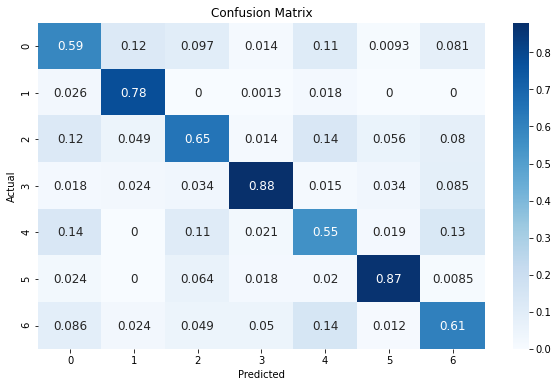

In [9]:
#test images
from sklearn.metrics import confusion_matrix
import seaborn as sn
emotion={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'} #for FER2013

print('Labels Dictionary:')
print(emotion)
print('Number of predition samples = ', len(x_test))
loaded_model = load_model('my_9_model.h5')
pred = loaded_model.predict(x_test)
cm = confusion_matrix( np.argmax(y_test,1),pred.argmax(1),normalize='pred')
#cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize =(10,6))
sn.heatmap(cm, annot=True, annot_kws={"size": 12},cmap=plt.cm.Blues) # font size
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()